# Installations

In [ ]:
# Installations

# install once necessary libraries

!pip install pandas
!pip install -U scikit-learn
!pip install pm4py
!pip install kneed
!pip install torch

# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter


if __name__ == "__main__":
    # Read the CSV file
    dataframe = pd.read_csv('model_A.csv', sep=',')  

    # Drop the first column without knowing its name
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)

    # Format the dataframe
    dataframe = pm4py.format_dataframe(
        dataframe, 
        case_id='case:concept:name', 
        activity_key='concept:name', 
        timestamp_key='time:timestamp'
    )

    # Convert the dataframe to event log
    log = log_converter.apply(dataframe)
    
dataframe

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)


,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,@@index,@@case_index
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,0,0
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,1,0
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2,0
3,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,3,0
4,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,4,0
...,...,...,...,...,...,...,...,...,...
60844,10933,COMPLETE,A_ACCEPTED,2012-03-01 20:17:22.457000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60844,13085
60845,10933,COMPLETE,A_FINALIZED,2012-03-01 20:22:38.593000+01:00,2012-02-29 23:43:09.766000+01:00,214373,8500,60845,13085
60846,112,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60846,13086
60847,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000,60847,13086


# Data Preprocessing

In [2]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

q = 10

# Group the dataframe by case and combine the activities into a list
grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='traces')

# Convert all activities to lowercase for consistency
grouped['traces'] = grouped['traces'].apply(lambda x: [activity.lower() for activity in x])

# Train a Word2Vec model
model = Word2Vec(sentences=grouped['traces'], vector_size=q, window=5, min_count=1, workers=4)

# Function to concatenate and pad vectors of each activity in a trace
def trace_to_padded_vector(trace, model, max_length, vector_size=q):
    # Get the vector for each activity in the trace
    vectors = [model.wv[activity] for activity in trace if activity in model.wv]
    
    # Concatenate all vectors
    concatenated_vector = np.concatenate(vectors) if vectors else np.zeros(0)

    # Determine the length of padding required
    padding_length = max_length - concatenated_vector.shape[0]

    # Check if padding is needed
    if padding_length > 0:
        # Pad with zeros
        concatenated_vector = np.pad(concatenated_vector, (0, padding_length), mode='constant')
    elif padding_length < 0:
        # Truncate the vector if it's longer than max_length
        concatenated_vector = concatenated_vector[:max_length]

    return concatenated_vector

# Determine the maximum length for padding (you might need to adjust this)
# Example: max_length = longest trace * vector_size
max_length = max(grouped['traces'].apply(len)) * q

# Map each trace to its concatenated and padded vector representation
padded_trace_vectors = grouped['traces'].apply(lambda x: trace_to_padded_vector(x, model, max_length))

trace_vectors = padded_trace_vectors

# Clustering

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

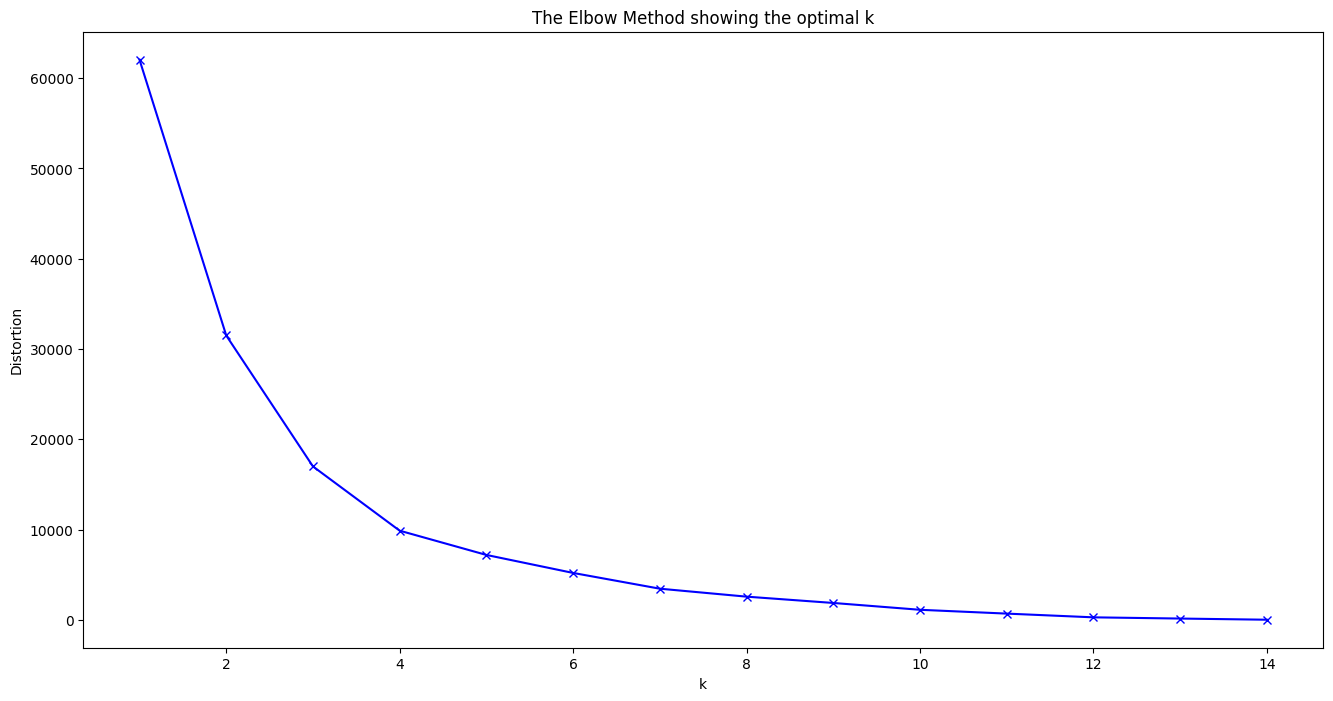

Optimal number of clusters: 4


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np

# Convert trace_vectors into a 2D array, which can be directly fed to KMeans
trace_vectors = np.array(trace_vectors.tolist())

distortions = []
K = range(1, 15)  # Check for number of clusters from 1 to 15, adjust according to your data
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(trace_vectors)
    distortions.append(kmeans.inertia_)  # Inertia: sum of squared distances of samples to their closest cluster center

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Find the elbow point using KneeLocator
kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print("Optimal number of clusters:", kl.elbow)

In [4]:
from sklearn.cluster import KMeans

# Number of clusters
k = kl.elbow

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
kmeans.fit(trace_vectors)

# Predict the clusters for each trace
clusters = kmeans.predict(trace_vectors)

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Cluster Evaluation

In [5]:
# the value of the silhouette coefficient ranges between -1 and 1
# value close to 1 is considered as good

from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(trace_vectors, clusters)

print(f"Silhouette Coefficient: {silhouette_avg:.2f}")

Silhouette Coefficient: 0.79


# Token-Based Replay for Conformance Checking

In [6]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("Model_A_corrected.bpmn")

# 3. Convert the BPMN to a Petri net
net, im, fm = pm4py.convert_to_petri_net(bpmn_graph)

# 4. Perform alignment-based conformance checking
alignments = alignments_petri.apply(log, net, im, fm)

# Calculate and print diagnostics
fit_traces = sum(1 for trace in alignments if trace['fitness'] == 1.0)

print(f"Total traces: {len(log)}")
print(f"Conform traces: {fit_traces}")
print(f"Non-Conform traces: {len(log) - fit_traces}")

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Total traces: 13087
Conform traces: 11497
Non-Conform traces: 1590


# Happy Cluster

In [7]:
labels = kmeans.labels_

# Identify the dominant cluster
from collections import Counter
counter = Counter(labels)
happy_cluster = counter.most_common(1)[0][0]
print(f"Happy Cluster: {happy_cluster}")

Happy Cluster: 1


In [8]:
# Get the indices of the data points belonging to the happy cluster
happy_cluster_indices = np.where(clusters == happy_cluster)[0]

# Use these indices to fetch the corresponding data points from the original data X
happy_cluster_data_points = trace_vectors[happy_cluster_indices, :]

# Calculate the centroid as the mean of these data points
happy_cluster_centroid = np.mean(happy_cluster_data_points, axis=0)

print("Centroid of happy cluster:", happy_cluster_centroid)

Centroid of happy cluster: [-0.16216724  0.4875502  -0.9811247   0.18315025  0.11521185 -0.42439494
  0.44945803 -0.1734658  -1.267473   -0.48801604 -0.77733314  0.92315936
  0.14860335  0.3734455  -0.36740893 -0.57525325  0.61914176  0.7092439
 -0.4532211   0.43098426  0.19131075  0.5683616   0.40871888 -0.26505584
  0.7552919  -0.32517904 -0.03459049  0.52242166 -0.8922459   0.2312545
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


# Distance Measurement

In [9]:
from scipy.spatial.distance import euclidean

# Calculate the Euclidean distance from each data point in X to the happy_cluster_centroid
distances_to_centroid = [euclidean(trace_vectors[i], happy_cluster_centroid) for i in range(len(trace_vectors))]

# Results overview

In [10]:
# create dataframe with necessary information for distance measurement

grouped = dataframe.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

results = pd.DataFrame(grouped['trace'])

results['cluster'] = clusters

conformity_array = [int(trace['fitness']) for trace in alignments]
results['conform'] = conformity_array

results['distance'] = distances_to_centroid

In [11]:
summary = results.groupby('cluster').agg(
    count=pd.NamedAgg(column='trace', aggfunc='size'),
    conform_count=pd.NamedAgg(column='conform', aggfunc='sum')
).reset_index()

print("cluster\tcount\tconform_count")
for _, row in summary.iterrows():
    print(f"{row['cluster']}\t{row['count']}\t{row['conform_count']}")

cluster	count	conform_count
0	2257	2185
1	5720	5720
2	2246	1055
3	2864	2537


# Evaluation

/Users/mert2/.conda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


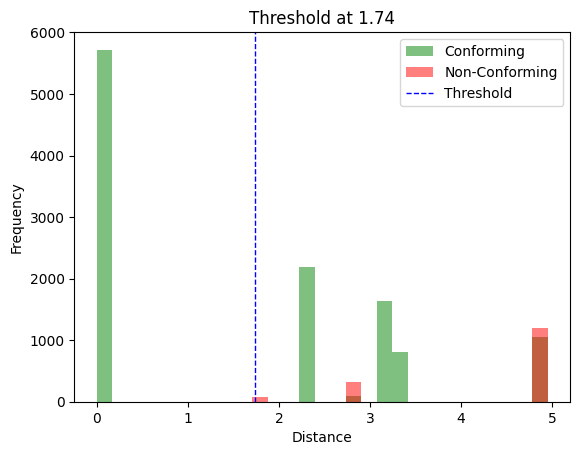

In [12]:
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')
plt.show()

In [13]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [14]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.553


In [15]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.988


In [16]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.498


In [17]:
# Calculate f1
f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.662


# Dev (Non Conform Traces)

In [18]:
# Calculate precision for Dev
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.208


In [19]:
# Calculate recall for Dev
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.957


# No Dev (Conform Traces)

In [20]:
# Calculate precision for No Dev
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.988


In [21]:
# Calculate recall for No Dev
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.498


# AUC_ROC

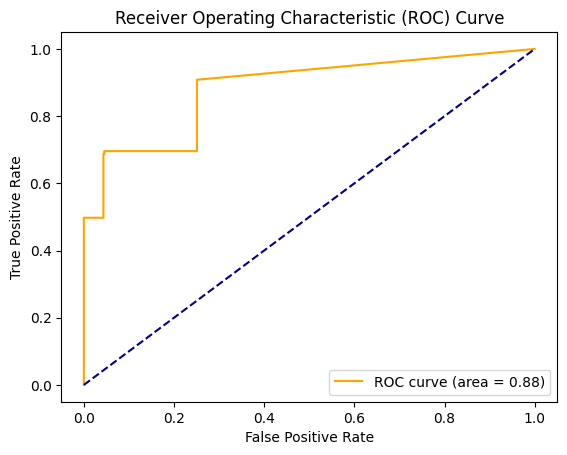

ROC AUC: 0.881


In [22]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")